Loading data from: /kaggle/input/df3333/df3.csv
Initial rows: 2589
Rows after initial preprocessing: 2568

--- Creating 'Rolling' Feature Set ---
Using 'Rolling' feature set with 56 features.
Rows after feature engineering and dropna: 2538
Optimization training data size: 1741

--- Starting Optuna Optimization for LightGBM (100 trials) ---


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  0%|          | 0/100 [00:00<?, ?it/s]

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.



Best hyperparameters found by Optuna for LightGBM:
{'n_estimators': 2500, 'learning_rate': 0.021077311457135765, 'num_leaves': 74, 'max_depth': 10, 'feature_fraction': 0.8222286037186061, 'bagging_fraction': 0.9850060438607955, 'bagging_freq': 4, 'lambda_l1': 5.572016295453607e-05, 'lambda_l2': 18.29961000033268, 'min_child_samples': 19}
Best CV RMSE during optimization: 5.1967

--- Running Adaptive Forecast with 56 features ---
Forecasting from 2022-02-24 to 2025-04-04 (795 steps)


Adaptive Steps (56 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished adaptive forecast. Total time: 14739.12 seconds.

--- Final Evaluation (Optimized LightGBM with Rolling Features) ---

Optimized LightGBM (Rolling Feats) Adaptive Forecast Results:
Target: Realized_Volatility_Daily
Period: 2022-02-24 to 2025-04-04
------------------------------
RMSE:  3.77
MAE:   1.80
QLIKE: 0.0039
------------------------------


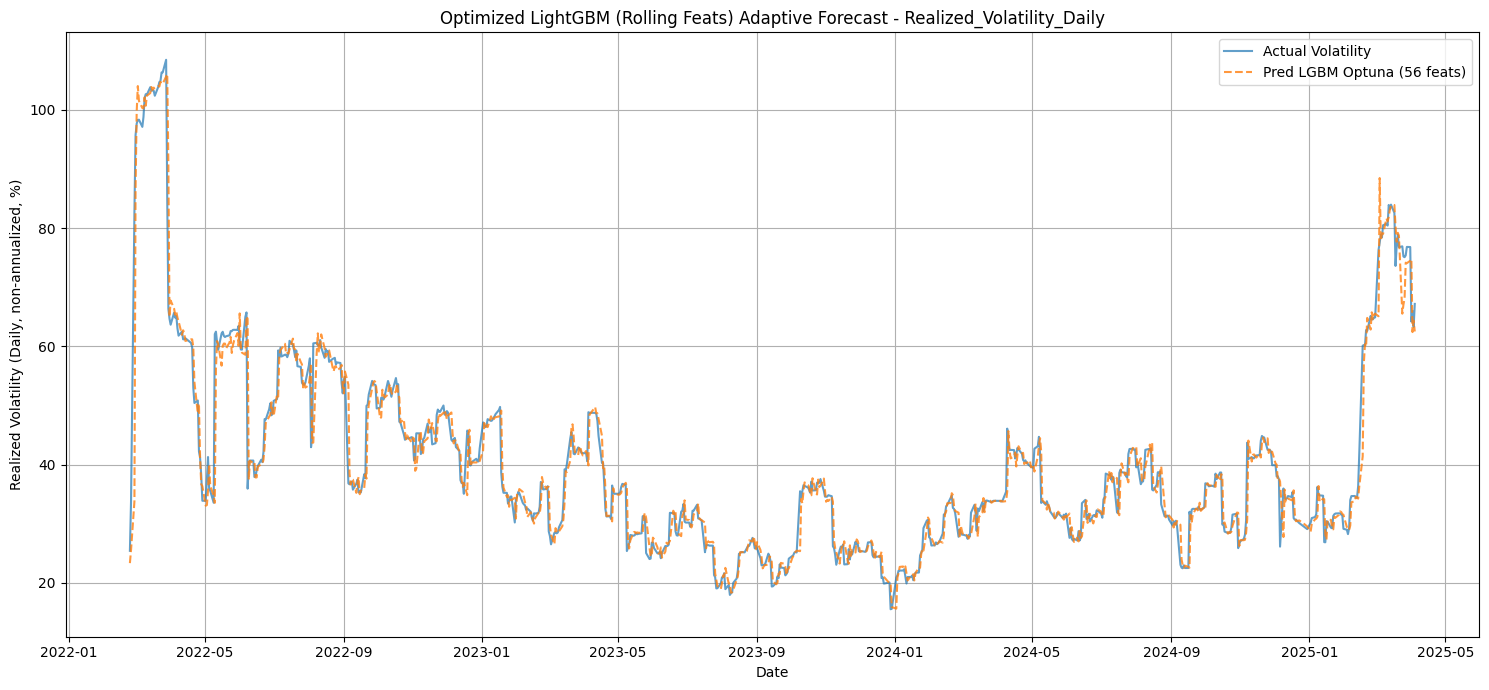

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
import time
import optuna
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

def qlike_loss(y_true, y_pred, epsilon=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = (y_true > epsilon) & (y_pred > epsilon)
    if mask.sum() == 0:
        return np.nan
    y_true, y_pred = y_true[mask], y_pred[mask]
    ratio = y_true / (y_pred + epsilon)
    ratio = np.maximum(ratio, epsilon)
    loss = ratio - np.log(ratio) - 1
    return np.mean(loss)

def add_lag_features(df, target_col, lags):
    df_out = df.copy()
    all_new_features = []
    cols_to_lag = ['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume', 'Log_Return', 'Realized_Volatility_Daily']
    if target_col not in cols_to_lag and target_col in df_out.columns:
        cols_to_lag.append(target_col)
    for col in cols_to_lag:
        if col in df_out.columns:
            for lag in lags:
                feature_name = f'{col}_lag_{lag}'
                if feature_name not in df_out.columns:
                    df_out[feature_name] = df_out[col].shift(lag)
                    all_new_features.append(feature_name)
    return df_out, all_new_features

def add_rolling_features(df, windows):
    df_out = df.copy()
    all_new_features = []
    cols_to_roll = ['Adj Close', 'Log_Return', 'Realized_Volatility_Daily', 'Volume', 'High', 'Low']
    for col in cols_to_roll:
         if col in df_out.columns:
            for window in windows:
                mean_feat, std_feat = f'{col}_roll_mean_{window}', f'{col}_roll_std_{window}'
                if mean_feat not in df_out.columns:
                    df_out[mean_feat] = df_out[col].rolling(window=window, min_periods=max(1, window // 2)).mean()
                    all_new_features.append(mean_feat)
                if std_feat not in df_out.columns:
                    df_out[std_feat] = df_out[col].rolling(window=window, min_periods=max(1, window // 2)).std()
                    all_new_features.append(std_feat)
    return df_out, all_new_features

def objective(trial, df_train, features, target_col, n_splits_cv):
    params = {
        'objective': 'regression_l1', 'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 200, 3000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 20.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 20.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 3, 60),
        'verbose': -1, 'n_jobs': -1, 'seed': 42, 'boosting_type': 'gbdt',
        'device': 'gpu'
    }

    X = df_train[features]
    y = df_train[target_col]
    valid_indices = X.dropna().index.intersection(y.dropna().index)
    if len(valid_indices) < n_splits_cv * 2:
        return np.inf
    X = X.loc[valid_indices].copy()
    y = y.loc[valid_indices].copy()
    X.columns = X.columns.astype(str)

    tscv = TimeSeriesSplit(n_splits=n_splits_cv)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        model = lgb.LGBMRegressor(**params)
        eval_set = [(X_val, y_val)]
        callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
        try:
            model.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)
            preds = model.predict(X_val)
            rmse = mean_squared_error(y_val, preds, squared=False)
            scores.append(rmse)
        except Exception:
            scores.append(np.inf)
    return np.mean([s for s in scores if np.isfinite(s)]) if any(np.isfinite(s) for s in scores) else np.inf

def run_single_model_adaptive_forecast(df_full_features, features, target_col, model_params, train_end_date, forecast_end_date):
    print(f"\n--- Running Adaptive Forecast with {len(features)} features ---")
    predictions = {}
    start_time_total = time.time()
    forecast_index = df_full_features.loc[train_end_date + pd.Timedelta(days=1):forecast_end_date].index
    forecast_index = forecast_index.unique().sort_values()
    if forecast_index.empty:
        return pd.Series(dtype=float)
    print(f"Forecasting from {forecast_index.min().strftime('%Y-%m-%d')} to {forecast_index.max().strftime('%Y-%m-%d')} ({len(forecast_index)} steps)")

    run_params = model_params.copy()
    run_params.pop('early_stopping_round', None)
    run_params.pop('metric', None) 

    model_class = lgb.LGBMRegressor

    for current_date in tqdm(forecast_index, desc=f"Adaptive Steps ({len(features)} feats)"):
        try:
            current_date_loc = df_full_features.index.get_loc(current_date)
            if current_date_loc == 0:
                continue
            train_end_idx_date = df_full_features.index[current_date_loc - 1]
        except (KeyError, IndexError):
            continue

        current_train_data = df_full_features[df_full_features.index <= train_end_idx_date].copy()
        current_train_data['target_for_train'] = current_train_data[target_col].shift(-1)
        current_train_data.dropna(subset=features + ['target_for_train'], inplace=True)

        if current_train_data.empty:
            predictions[current_date] = np.nan
            continue

        X_train = current_train_data[features]
        y_train = current_train_data['target_for_train']
        X_train.columns = X_train.columns.astype(str)

        model = model_class(**run_params)
        try:
            model.fit(X_train, y_train)
        except Exception as e:
            print(f"Fit Error {current_date}: {e}")
            predictions[current_date] = np.nan
            continue

        try:
            features_for_prediction = df_full_features.loc[[train_end_idx_date]][features]
            features_for_prediction.columns = features_for_prediction.columns.astype(str)
        except KeyError:
            predictions[current_date] = np.nan
            continue

        if features_for_prediction.isnull().any().any():
            predictions[current_date] = np.nan
        else:
             try:
                 pred = model.predict(features_for_prediction)[0]
                 predictions[current_date] = pred
             except Exception as e:
                 print(f"Predict Error {current_date}: {e}")
                 predictions[current_date] = np.nan

    print(f"Finished adaptive forecast. Total time: {time.time() - start_time_total:.2f} seconds.")
    return pd.Series(predictions).sort_index()

if __name__ == "__main__":
    DATA_FILE_PATH = '/kaggle/input/df3333/df3.csv'
    TARGET_VARIABLE = 'Realized_Volatility_Daily'
    TRAIN_END_DATE = pd.to_datetime("2022-02-23")
    FORECAST_END_DATE = pd.to_datetime("2025-04-04")
    N_SPLITS_CV_OPTUNA = 5
    N_TRIALS_OPTUNA = 100

    print(f"Loading data from: {DATA_FILE_PATH}")
    df = pd.read_csv(DATA_FILE_PATH, parse_dates=['Date'], index_col='Date')
    df.sort_index(inplace=True)
    print(f"Initial rows: {len(df)}")
    required_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"Missing required columns: {required_cols}")
    df['Adj Close'] = df['Adj Close'].replace(0, np.nan).ffill()
    df['Log_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    window = 21
    annualization_factor = 260
    df['Realized_Volatility_Daily'] = df['Log_Return'].rolling(window=window).std() * np.sqrt(annualization_factor) * 100 # Skalowanie do %
    df.dropna(inplace=True)
    print(f"Rows after initial preprocessing: {len(df)}")

    print("\n--- Creating 'Rolling' Feature Set ---")
    df_features_rolling = df.copy()
    df_features_rolling, base_features_list = add_lag_features(df_features_rolling, TARGET_VARIABLE, lags=[1])
    df_features_rolling, rolling_features_list = add_rolling_features(df_features_rolling, windows=[5, 10, 21, 63])
    ROLLING_FEATURES = sorted(list(set(base_features_list + rolling_features_list)))
    print(f"Using 'Rolling' feature set with {len(ROLLING_FEATURES)} features.")
    df_features_rolling.dropna(subset=ROLLING_FEATURES, inplace=True)
    print(f"Rows after feature engineering and dropna: {len(df_features_rolling)}")

    df_train_optuna = df_features_rolling[df_features_rolling.index <= TRAIN_END_DATE].copy()
    df_train_optuna['target'] = df_train_optuna[TARGET_VARIABLE].shift(-1)
    df_train_optuna.dropna(subset=ROLLING_FEATURES + ['target'], inplace=True)
    print(f"Optimization training data size: {len(df_train_optuna)}")

    print(f"\n--- Starting Optuna Optimization for LightGBM ({N_TRIALS_OPTUNA} trials) ---")
    study = optuna.create_study(direction='minimize')
    def objective_with_args(trial):
        return objective(trial, df_train_optuna, ROLLING_FEATURES, 'target', N_SPLITS_CV_OPTUNA)
    study.optimize(objective_with_args, n_trials=N_TRIALS_OPTUNA, show_progress_bar=True)

    best_params_optuna = study.best_params
    print("\nBest hyperparameters found by Optuna for LightGBM:")
    print(best_params_optuna)
    print(f"Best CV RMSE during optimization: {study.best_value:.4f}")

    final_lgbm_params = {
        'objective': 'regression_l1', 'verbose': -1, 'n_jobs': -1,
        'seed': 42, 'boosting_type': 'gbdt',
        'device': 'gpu'
    }
    final_lgbm_params.update(best_params_optuna)

    preds_lgbm_optuna_rolling = run_single_model_adaptive_forecast(
        df_features_rolling,
        ROLLING_FEATURES,
        TARGET_VARIABLE,
        final_lgbm_params, 
        TRAIN_END_DATE,
        FORECAST_END_DATE
    )

    print("\n--- Final Evaluation (Optimized LightGBM with Rolling Features) ---")
    if not preds_lgbm_optuna_rolling.empty:
        common_index_opt = preds_lgbm_optuna_rolling.index
        actuals_opt = df.loc[common_index_opt, TARGET_VARIABLE]

        comparison_df_opt = pd.DataFrame({
            'Actual': actuals_opt,
            'Pred_LGBM_Optuna_Rolling': preds_lgbm_optuna_rolling.loc[common_index_opt]
        }).dropna()

        if not comparison_df_opt.empty:
            rmse_opt = mean_squared_error(comparison_df_opt['Actual'], comparison_df_opt['Pred_LGBM_Optuna_Rolling'], squared=False)
            mae_opt = mean_absolute_error(comparison_df_opt['Actual'], comparison_df_opt['Pred_LGBM_Optuna_Rolling'])
            qlike_opt = qlike_loss(comparison_df_opt['Actual'], comparison_df_opt['Pred_LGBM_Optuna_Rolling'])

            print("\nOptimized LightGBM (Rolling Feats) Adaptive Forecast Results:")
            print(f"Target: {TARGET_VARIABLE}")
            print(f"Period: {comparison_df_opt.index.min().strftime('%Y-%m-%d')} to {comparison_df_opt.index.max().strftime('%Y-%m-%d')}")
            print("-" * 30)
            print(f"RMSE:  {rmse_opt:.2f}")
            print(f"MAE:   {mae_opt:.2f}")
            print(f"QLIKE: {qlike_opt:.4f}")
            print("-" * 30)

            plt.figure(figsize=(15, 7))
            plt.plot(comparison_df_opt.index, comparison_df_opt['Actual'], label='Actual Volatility', alpha=0.7)
            plt.plot(comparison_df_opt.index, comparison_df_opt['Pred_LGBM_Optuna_Rolling'], label=f'Pred LGBM Optuna ({len(ROLLING_FEATURES)} feats)', linestyle='--', alpha=0.8)
            plt.title(f'Optimized LightGBM (Rolling Feats) Adaptive Forecast - {TARGET_VARIABLE}')
            plt.xlabel('Date')
            plt.ylabel('Realized Volatility (Daily, non-annualized, %)')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig('lgbm_optuna_rolling_adaptive_forecast.png')
            plt.show()
        else:
            print("Could not evaluate the optimized model (e.g., all NaNs or no common index).")
    else:
        print("No valid predictions generated for the optimized model.")